In [35]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
autoreload 2

In [37]:
import os
import sys
import time
import argparse
import datetime
import math
import pickle
from tqdm import tqdm as tqdm
import pandas as pd

import torchvision
import torchvision.transforms as transforms

import torch
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

from utils import DEVICE

Handle Data

In [227]:
valid_size = 0.1
batch_size = 32
# convert data to a normalized torch.FloatTensor
transform_train = transforms.Compose([
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_data = torchvision.datasets.CIFAR10(
                root='../data', 
                train=True,
                download=True, 
                transform=transform_train)

test_data = torchvision.datasets.CIFAR10(
                root='../data', 
                train=False,
                download=True, 
                transform=transform_test)


# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(valid_size * num_train)
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(
                    train_data, 
                    batch_size=batch_size,
                    sampler=train_sampler,
                    num_workers=2)

valid_loader = torch.utils.data.DataLoader(
                    train_data, 
                    batch_size=batch_size, 
                    sampler=valid_sampler, 
                    num_workers=2)

test_loader = torch.utils.data.DataLoader(
                    test_data, 
                    batch_size=batch_size,
                    num_workers=2)

#classes = ('plane', 'car', 'bird', 'cat',
 #          'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = range(10)

Files already downloaded and verified
Files already downloaded and verified


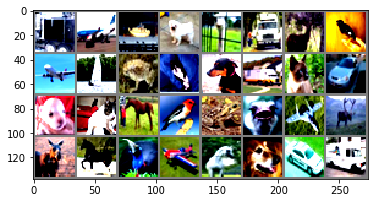

    9     0     8     5


In [228]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = iter(train_loader).next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Define Training functions

## Define how to train a frequentist model

In [229]:
class TrainLogger:
    def __init__(self, name, model, train_loader, valid_loader, test_loader):
        self.name = name
        self.model = model
        self.log_dic = []
        self.epoch, self.n_epochs = 0, 0
        self.optimizer = optim.Adam(model.parameters())
        self.scheduler = optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=[33, 66], gamma=0.3)
        self.xent = nn.CrossEntropyLoss()
        
    def _accuracy(self, outputs, labels, batch_size = batch_size):
        _, preds = outputs.max(1)
        correct = torch.eq(preds, labels).sum().item()
        return correct/len(labels)
    
    def _eval(self, loader):
        accs = []
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = self.model(images)
                accs.append(self._accuracy(outputs, labels))
        return np.mean(accs)
        
    def loss_step(self, batch_id, outputs, labels):
        loss = self.xent(outputs[0], labels)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return dict(loss=loss.item())
        
    def train(self, n_epochs, n_samples = 1, callbacks = []):
        # call callbacks at the end of each epoch
        print('Training Model', self.name)
        self.n_epochs += n_epochs
        self.model.train()
        epoch_range = range(self.epoch, n_epochs)
        for self.epoch in epoch_range:
            self.scheduler.step(self.epoch)
            batch_log = {'train_acc':[]}
            for batch_id, (images, labels) in enumerate(train_loader):
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = [self.model(images) for _ in range(n_samples)]
                batch_log['train_acc'].append(self._accuracy(outputs[0], labels))
                loss_dic = self.loss_step(batch_id, outputs, labels)
                for loss_name, loss_value in loss_dic.items():
                    if not loss_name in batch_log:
                        batch_log[loss_name] = []
                    batch_log[loss_name].append(loss_value)

            means = {key:np.mean(values) for key, values in batch_log.items()}
            self.log(**means)
            self.log(val_acc=self._eval(valid_loader))

            self.display()
            for cb in callbacks:
                cb()
        self.epoch += 1
    
    def test(self):
        print('\n{0} Test Accuracy: {1:.2f} %'.format(self.name, 100*self._eval(test_loader)))
        
            
    def log(self, mode = 'epoch', **kwargs):
        while len(self.log_dic) < self.epoch+1:
            self.log_dic.append({})
        self.log_dic[self.epoch].update(kwargs)
        
    def display(self, mode='text'):
        print('\rEpoch {0}/{1} \t \t Loss: {2:.3f}, Train Acc: {3:.2f}%, Val Acc: {4:.2f}%'.format(
                    self.epoch+1, self.n_epochs, self.log_dic[self.epoch]['loss'], 
                    100*self.log_dic[self.epoch]['train_acc'], 100*self.log_dic[self.epoch]['val_acc']), end = '')
        
    def save(self, save_file):
        pd.DataFrame(self.log_dic).to_csv(save_file)

In [ ]:
from trainlogger import TrainLogger

In [241]:
class BayesTrainLogger(TrainLogger):
    def __init__(self, name, net, prior_nll, kl_weighting='normal'):
        super().__init__(name, net)
        self.model = BayesWrapper(name=name, net=net, prior_nll= prior_nll)
        self.m = len(train_loader)
        if kl_weighting == 'graves':
            self.beta = lambda batch_id: 2 ** (self.m - (batch_id + 1)) / (2 ** self.m - 1) 
        else:
            self.beta = lambda batch_id: 1/self.m

    def loss_step(self, batch_id, outputs, labels):
        kl, xe, loss = self.model.step(outputs, labels, self.beta(batch_id))
        return dict(kl=kl.item(), xe=xe.item(), loss=loss.item())

# Define and Train Models

In [231]:
from trainlogger import TrainLogger

CRITICAL:root:Cannot load caffe2.python. Error: /opt/caffe2/build/caffe2/python/caffe2_pybind11_state.so: undefined symbol: _ZN5fLI6438FLAGS_caffe2_max_keep_on_shrink_memoryE


## Train models

In [235]:
import models
N_EPOCHS = 100

In [236]:
# Frequentist AlexNet
alexnet = TrainLogger('AlexNet', models.AlexNet().to(DEVICE))
alexnet.train(n_epochs = N_EPOCHS)
alexnet.save('results/E1_CIFAR10_AlexNet.csv')

Training Model AlexNet
Epoch 100/100 	 	 Loss: 0.001, Train Acc: 99.98%, Val Acc: 75.40%

In [237]:
# Frequentist AlexNet with Dropout
alexnetdp = TrainLogger('AlexNet', models.AlexNet(dropout=.5).to(DEVICE))
alexnetdp.train(n_epochs = N_EPOCHS)
alexnetdp.save('results/E1_CIFAR10_AlexNetDropout.csv')

Training Model AlexNet
Epoch 100/100 	 	 Loss: 0.130, Train Acc: 95.57%, Val Acc: 72.19%

In [242]:
# Bayesian AlexNet
bayesalexnet = BayesTrainLogger(name='BayesAlexNet', 
                        net=models.AlexNet().to(DEVICE), 
                        prior_nll=prior_nll)

bayesalexnet.train(n_epochs = N_EPOCHS, 
                   n_samples=2)
bayesalexnet.save('results/E1_CIFAR10_BayesAlexNet.csv')

Training Model BayesAlexNet
Epoch 100/100 	 	 Loss: 11325.583, Train Acc: 95.90%, Val Acc: 73.83%

In [ ]:
# Bayesian AlexNet with Dropout
bayesalexnetdp = BayesTrainLogger(name='BayesAlexNetDp', 
                        net=models.AlexNet(dropout=.5).to(DEVICE), 
                        prior_nll=prior_nll)
bayesalexnetdp.train(n_epochs = N_EPOCHS, 
                     n_samples=2)
bayesalexnetdp.save('results/E1_CIFAR10_BayesAlexNetDropout.csv')

Training Model BayesAlexNetDp
Epoch 24/100 	 	 Loss: 10831.831, Train Acc: 83.02%, Val Acc: 72.05%

In [201]:
lenet = TrainLogger('LeNet', models.LeNet().to(DEVICE))
lenet.train(n_epochs = N_EPOCHS)
lenet.save('results/E1_CIFAR10+_LeNet.csv')

Training Model LeNet
Epoch 100/100 	 	 Loss: 0.509, Train Acc: 81.62%, Val Acc: 65.19%

In [207]:
lenetdp = TrainLogger('LeNetDropout', models.LeNetDropout().to(DEVICE))
lenetdp.train(n_epochs = N_EPOCHS)
lenetdp.save('results/E1_CIFAR10+_LeNetDropout.csv')

Training Model LeNetDropout
Epoch 100/100 	 	 Loss: 0.901, Train Acc: 69.03%, Val Acc: 64.65%

IndexError: list index out of range

# Test

In [ ]:
for model in (alexnet, alexnetdp, bayesalexnet, bayesalexnetdp):
    model.test()

In [250]:
import plotly.graph_objs as go

In [262]:
fig = go.FigureWidget([go.Scatter(
    name = tlg.name, y = [e['val_acc'] for e in tlg.log_dic])
                      for tlg in (alexnet, alexnetdp,
                                   bayesalexnet, bayesalexnetdp)])
fig.layout.title = 'Val Accuracies CIFAR 10'

In [261]:
alexnetdp.name = 'AlexNetDp'

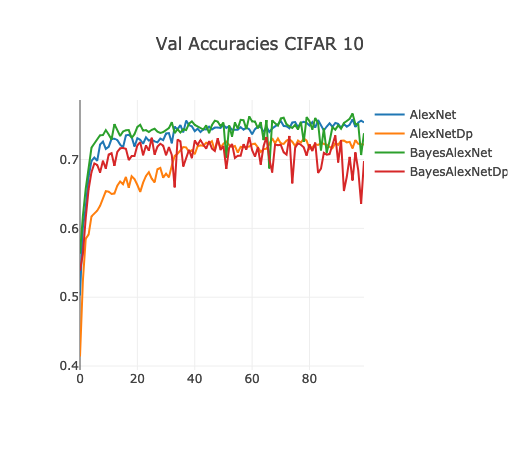

In [263]:
import plotly.offline as py
py.iplot(fig)

In [259]:
a=1